(group_fairness_metrics)=

# Group Fairness Metrics

There have been many attempts to formalize fairness in mathematical criteria, but by far the most prominent notion of fairness is group fairness. The computation of group fairness metrics is best understood as the result of a disaggregated analysis, in which we measure the extent to which a particular _metric_ differs across _groups_ of individuals. In technical literature, these groups are typically referred to as sensitive groups and are often - but not always - defined based on legally protected characteristics such as race and gender.

Group fairness metrics differ primarily based on _which_ group statistic is required to be equal across groups. We can distinguish three main categories: metrics based on [independence](independence_metrics), [misclassification rates](misclassification_metrics), and [calibration](calibration_metrics).

In the remainder of this section, we formally define several group fairness criteria in the classification scenario and illustrate how they can be computed using the Python library `fairlearn`.

Throughout this section, we use the following notation:

- $X$ : the set of input features;
- $Y$ : the 'ground truth' labels;
- $\widehat{Y}$ : the predictions;
- $A$ : the sensitive feature(s) that measure sensitive characteristic(s).

## Running Example

As a running example, we train a logistic regression model on a synthetic hiring data set.

The data set has a few features that can be used for predictions, including `years_of_experience`, the `test_score` of an applicant on a job-related test, the `interview_score` that is provided by the person who interviewed the candidate, the `average_grade` the applicant achieved in their highest degree, and finally the applicant's `gender`. The target variable is `hired`.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# load data
data = pd.read_csv('hiring.csv')
# display data set
display(data.head())

# prepare data set
y = data['hired']
A = data['gender']
X = data.drop(['hired', 'gender'], axis=1)

# convert categorical  to dummy variables
X[['female', 'male', 'non_binary']] = pd.get_dummies(A)

# split into train and test set
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, random_state=0, test_size=0.5)

# train classifier
lr = LogisticRegression()
lr.fit(X_train, y_train)

,years_of_experience,test_score,interview_score,average_grade,gender,hired
0,1,2,2,6,male,0
1,1,1,1,6,female,0
2,2,2,2,6,female,0
3,3,1,2,7,male,0
4,2,1,2,6,male,0


LogisticRegression()

```{caution}

The data that will be used throughout this section is **synthetic** and is merely used for illustrative purposes. **I do *not* claim in any way that this data set and model are representative of actual hiring practices**.

```

(independence_metrics)=

## Independence

When we think of discrimination, an intuitive notion of fairness is independence: whether an individual receives a particular output, should not depend on sensitive group membership. For example, in our hiring scenario, one may argue that whether an applicant is hired should not depend on their gender.

(demographic_parity)=

### Demographic parity

The first criterion that we will discuss is _demographic parity_. In a classification scenario, demographic parity requires that for all values of $y$ and $a$:

$$P(\hat{Y} = y \mid A = a) = P(\hat{Y} = y \mid A = a')$$

In other words, the probability of receiving a particular prediction should be **independent** of sensitive group membership. In a binary classification scenario, this criterion can be checked by comparing selection rates, i.e., the proportion of predicted positives, across groups. When positive predictions correspond to a resource that is distributed between people, demographic parity can be interpreted as a measure of potential allocation harm.

In many cases, we might be interested to measure not just whether demographic parity holds exactly, but also _to what extent_ it is violated. A popular way to summarize the comparison of group statistics is to compute the maximum _difference_ between sensitive groups:

$$\max_{a, a' \in A}( P(\hat{Y} = 1 \mid A = a) - P(\hat{Y} = 1 \mid A = a') )$$

Alternatively, we can compute the minimum _ratio_ between groups:

$$\min_{a, a' \in A}(P(\hat{Y} = 1 \mid A = a) / P(\hat{Y} = 1 \mid A = a'))$$

Note that demographic parity depends on predictions $\hat{Y}$ and sensitive feature(s) $A$, but **not** on the 'ground-truth' target variable $Y$. A direct consequence of this fact is that if group-specific base rates $p_a = P(Y=1 \mid A=a)$ (i.e., the proportion of positives) differs between groups **a perfect classifier cannot satisfy demographic parity**.

```{tip}
Demographic parity as a fairness metric is *very loosely* inspired by the legal concepts of indirect discrimination in EU law and disparate impact in US labor law - but satisfying the metric definitely does not directly imply legal compliance!

```

In `fairlearn`, we can easily compute group-specific statistics and subsequent aggregations using {class}`fairlearn.metrics.MetricFrame`.

In [2]:
# compute metrics by group
from fairlearn.metrics import MetricFrame, selection_rate

mf = MetricFrame(
    metrics={"selection rate": selection_rate},
    y_true=y_test,  # is ignored
    y_pred=lr.predict(X_test),
    sensitive_features=A_test,
)

# print results
display(mf.by_group)
print("Overall selection rate: %.2f" % mf.overall.iloc[0])

# compute demographic parity as the max difference between groups
print("demographic parity difference: %.2f" % mf.difference(method="between_groups").iloc[0])

# compute demographic parity as the min ratio between groups
print("demographic parity ratio: %.2f" % mf.ratio(method="between_groups").iloc[0])

,selection rate
gender,
female,0.148649
male,0.226300
non_binary,0.107843


Overall selection rate: 0.19
demographic parity difference: 0.12
demographic parity ratio: 0.48


From these results, we can see that our model has a higher selection rate for `male` applicants compared to other applicants, particularly `non_binary` applicants. Without further context, we cannot conclude whether this disparity is problematic. However, the low selection rates of some group can hint towards potential allocation harm and calls for further investigation.

```{tip}
You can also directly compute the extent to which demographic parity is violated using
{py:func}`fairlearn.metrics.demographic_parity_difference` or {py:func}`fairlearn.metrics.demographic_parity_ratio`. These summary metrics are particularly convenient for hyperparameter tuning or monitoring.

For exploratory and manual inspections, I highly recommend sticking to {py:class}`fairlearn.metrics.MetricFrame`, as this allows you to make more detailed comparisons across groups. While the demographic parity difference indicates the (maximum) disparity, it does not tell you between which groups the disparity occurred, nor what the selection rates of those groups are.
```

### Conditional Demographic Parity

Apart from employment, there may be characteristics that, either from a legal or ethical perspective, legitimize differences between groups. Loosely inspired by these legal imperatives, {footcite:t}`Kamiran2013` put forward a notion of fairness that we will refer to as conditional demographic parity. This is a variant of demographic parity that allows for differences between groups, if these differences are justified, from a legal or ethical point of view, by a control feature.

Conditional group fairness is best illustrated by an example. Imagine a scenario in which women have a lower income, on average, than men. This may imply that women are treated unfairly. However, what if many women work fewer hours than men? In this case, the observed disparity can be (at least partly) explained by the lower number of working hours. Consequently, equalizing income between men and women would mean that women are paid more per hour than men. If we believe unequal hourly wages to be unfair, we can instead equalize income only between women and men who work similar hours. In other words, we minimize the difference that is still present _after_ controlling for working hours.

Formally, let $W$ be a control feature. Then, conditional demographic parity holds if, for all values of $y$, $a$, and $w$:

$$P(\hat{Y} = y \mid A = a, W=w) = P(\hat{Y} = y \mid A = a', W=w)$$

Conditional demographic parity is particularly relevant considering Simpson's paradox. This paradox states that if a correlation occurs in several different groups, it may disappear or even reverse when the groups are aggregated.

```{admonition} *Example:* Simpson's Paradox: Berkeley University Admissions
When considering all programs together, women were accepted less often than men, implying a gender bias. However, it turned out that women at Berkeley often apply for competitive programs with a relatively low acceptance rate. As a result, the overall acceptance rate of women in the aggregated data was lower -- even though the acceptance rate of women *within* each program was higher than the acceptance rate of men. Hence, if the admission's office would have tried to equalize the overall acceptance rate between men and women, men would have received an even lower acceptance rate.
```

In `fairlearn`, the `control_features` parameter allows you to compare group statistics across the values of a feature we wish to control for.

When we make comparisons across multiple variables (or variables with a high number of categories), the number of instances within a group can become very small. Small sample sizes can be problematic, as the group statistic estimates become less reliable. We can use {py:func}`fairlearn.metrics.count` to inspect the number of instances in a {py:class}`fairlearn.metrics.MetricFrame` along with the metrics of interest.

Let's see whether the disparity in selection rates can be explained by the `test_score` a participant achieved.

In [3]:
from fairlearn.metrics import count

# compute metrics by group
mf = MetricFrame(
    metrics={
        "selection rate": selection_rate,
        "count": count},
    y_true=y_test,  # is ignored
    y_pred=lr.predict(X_test),
    sensitive_features=A_test,
    control_features=X_test['test_score']
)

# display results
display(mf.by_group)
display(mf.difference())

selection rate  count
test_score gender                           
1          female            0.051282  195.0
           male              0.087571  354.0
           non_binary        0.046512   43.0
2          female            0.169591  171.0
           male              0.295337  193.0
           non_binary        0.108108   37.0
3          female            0.346154   78.0
           male              0.560748  107.0
           non_binary        0.227273   22.0

,selection rate,count
test_score,,
1,0.041059,311.0
2,0.187229,156.0
3,0.333475,85.0


Interestingly, the disparity in selection rates is much lower for participants with a low `test_score`. However, it is particularly high for participants with a very high `test_score`. As such, `test_score` does not adequately explain disparities.

However, note that the number of instances in some of the subgroups have become very small. In particular, there are only 22 instances for which `gender=non_binary` _and_ `test_score=3`. As such, the computed selection rate for this group is much less reliable - in practice, it may turn out to be much higher or lower than what we observe here.

```{note}
**Small sample sizes are a very common issue in fairness assessments** - particularly when we consider intersectional notions of fairness that consider multiple sensitive characteristics or cross-validation procedures that further split the data set into smaller portions. Sample size is an important factor to consider before you do any interventions based on your findings, as the estimations of group statistics can be very uncertain.

The issue of small sample sizes is further complicated by the multiple comparisons problem. If we want to statistically test whether a metric is significantly different for one group compared to other groups, we need to make many comparisons between groups. As the number of groups increases, the probability of making a wrong inference increases as well, requiring a stricter significance threshold for each individual comparison. When sample sizes are small, it becomes hard to draw any conclusions at all.

In some cases, it might be possible to collect more data, but statistically sound fairness assessments are still an active area of research.
```

(misclassification_metrics)=

## Misclassification Rates

The second set of fairness metrics that we will consider are related to misclassification rates.

(equalized_odds)=

### Equalized Odds

Equalized odds {footcite:p}`hardt2016equality` is one of the most commonly studied fairness metrics. It requires an equal distribution of classification errors across sensitive groups for all classes. Formally, equalized odds is satisfied if for all values of $y \in Y$ and $a, a' \in A$,

$$P(\hat{Y} = y \mid A = a, Y = y) = P(\hat{Y} = y \mid A = a', Y = y)$$

In a binary classification scenario, satisfying equalized odds boils down to equal group-specific false positive rates and false negative rates (or, equivalently, equal true negative rates and true positive rates). Essenstially, equalized odds requires that, given a particular 'ground-truth' label, the probability of receiving a predicted label is independent of sensitive group membership. For example, in our hiring scenario, a classifier that satisfies equalized odds is neither more likely to falsely _reject_ suitable `male` candidates compared `non_binary` or `female` candidates, nor is it more likely to falsely accept unsuitable candidates for some genders. As such, we can interpret equalized odds as one way to measure the risk of allocation harm or quality-of-service harm.

```{tip}

If you need a refresher on different evaluation metrics for classification models, check out the [Model Evaluation](model_evaluation_classification_metrics) section of the machine learning preliminaries.

```

Similar to the demographic parity difference, we can summarize the comparisons of the false positive rate and false negative rates as the maximum absolute difference between groups. We can further summarize equalized odds as the maximum between the false positive rate difference and false negative rate differnece. Formally, that is:

$$\max_{a, a' \in A, y \in Y}( \mid P(\hat{Y} = y \mid A = a, Y = y) - P(\hat{Y} = y \mid A = a', Y = y) \mid )$$

Alternatively, one can take the average over the maximum difference.

In `fairlearn`, we can compare the false positive rates and false negative rates across groups in a single {py:class}`fairlearn.metrics.MetricFrame`. Additionally, we can use {py:func}`fairlearn.metrics.equalized_odds_difference` to directly compute the maximum of the false positive rate difference and false negative rate difference.

In [4]:
from fairlearn.metrics import false_positive_rate, false_negative_rate, equalized_odds_difference

# compute metrics by group
mf = MetricFrame(
    metrics={
        'fpr' : false_positive_rate,
        'fnr' : false_negative_rate,
        },
    y_true=y_test,
    y_pred=lr.predict(X_test),
    sensitive_features=A_test
)

# display results
display(mf.by_group)
display(mf.difference())

# compute equalized odds difference directly
eod = equalized_odds_difference(
    y_true=y_test,
    y_pred=lr.predict(X_test),
    sensitive_features=A_test
)
print("equalized odds difference: %.2f" % eod)

,fpr,fnr
gender,,
female,0.040000,0.260870
male,0.055336,0.189189
non_binary,0.022727,0.357143


fpr    0.032609
fnr    0.167954
dtype: float64

equalized odds difference: 0.17


From these results we can conclude that the group-specific false negative rates differ a lot, while the false positive rates are relatively similar. This implies that the model more often falsely predicts `female` and especially `non_binary` applicants to be rejected compared to `male` applicants.

(equal_opportunity)=

### Equal Opportunity

Equal opportunity is a relaxation of equalized odds that only requires the true positive rate (or, equivalently, false negative rate) to be equal across groups. Formally, for all values of $a, a' \in A$:

$$P(\hat{Y} = 1 \mid A = a, Y = 1) = P(\hat{Y} = 1 \mid A = a', Y = 1)$$

```{tip}

Equal opportunity as a fairness metric is *very loosely* inspired by the egalitarian concept of equality of opportunity, which we will discuss in more detail in [a later chapter](philosophy_egalitarianism).

```

As we have seen before, the hiring model does not satisfy equal opportunity, as the false negative rates differ between sensitive groups.

(calibration_metrics)=

## Calibration

The calibration of a machine learning model reflects whether predicted probabilities are consistent with observed probabilities. For example, a model is well-calibrated if out of all instances that receive a confidence score of 0.7, the fraction of instances that actually belongs to the positive class is also 0.7.

```{tip}

You can find a refresher on calibration of machine learning models in the machine learning preliminaries section on [model calibration](model_calibration).

```

(equal_calibration)=

### Equal calibration

Calibration is particularly relevant to interpret the output of a predictive model in a risk assessment scenario. In those cases, the output of the machine learning model can be interpreted as a _risk score_ $R$. The equal calibration fairness metric requires that the model is equally calibrated for each sensitive group. That is, equal calibration holds if, for all values of $y \in Y$, $a \in A$, and $r \in R$, we have:

$$P(Y = y \mid A = a, \hat{R} = r) = P(Y = y \mid A = a', \hat{R} = r)$$

In other words, for each possible risk score, the probability that you belong to a particular class is the same, regardless of sensitive group membership. For example, given that an instance is predicted to belong to the negative class, the probability of actually belonging to the negative class is independent of sensitive group membership. Essensially, equal calibration requires that the _meaning_ of a particular score is the same, regardless of sensitive group membership.

We can evaluate the calibration of risk scores by plotting group-specific calibration curves.

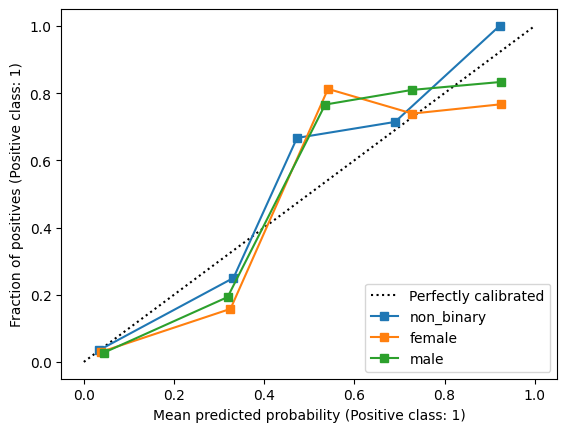

In [5]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

# display calibration curves
ax = plt.gca()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for gender in ['non_binary', 'female', 'male']:
    CalibrationDisplay.from_predictions(
        y_true=y_test[A_test==gender],
        y_prob=lr.predict_proba(X_test[A_test==gender])[:,1],
        n_bins=5,
        ax=ax,
        label=gender)
plt.show()

From this plot, we can see that the model is similarly calibrated for each of the `gender` categories.

In the binary classification scenario, equal calibration implies that the positive predictive value (which is equivalent to precision) and negative predictive value are equal across groups. That is:

$$P(Y = y \mid A = a, \hat{Y} = y) = P(Y = y \mid A = a', \hat{Y} = y)$$

As with equalized odds, equal calibration in the binary classification scenario can be summarized as the maximum difference in positive predictive value difference and negative predictive value difference:

$$\max_{a, a' \in A, y \in Y}P(Y = y \mid A = a, \hat{Y} = y) - P(Y = y \mid A = a', \hat{Y} = y)$$

In [6]:
from sklearn.metrics import precision_score

# first, we define a function to compute the negative predictie value
def negative_predictive_value_score(y_true, y_pred, **kwargs):
    """
    NPV is not in scikit-learn, but is the same as PPV but with 0 and 1 swapped.
    """
    return precision_score(y_true, y_pred, pos_label=0, **kwargs)

# compute metrics
mf = MetricFrame(
    metrics={
        "positive predictive value": precision_score,
        "negative predictive value": negative_predictive_value_score,
    },
    y_true=y_test,
    y_pred=lr.predict(X_test),
    sensitive_features=A_test,
)
display(mf.by_group)

,positive predictive value,negative predictive value
gender,,
female,0.772727,0.952381
male,0.810811,0.944664
non_binary,0.818182,0.945055


Again, we can see that the hiring classifier is similarly calibrated, as the group-specific positive and negative predictive values are very close.

```{tip}
In `fairlearn` we can define a custom fairness metric for NPV using {py:func}`fairlearn.metrics.make_derived_metric`. This function takes as parameters `metric` (a callable metric such as {py:func}`sklearn.metrics.recall_score` or {py:func}`fairlearn.metrics.false_positive_rate`) and `transform` (a string indicating the type of transformation, e.g., `difference` or `group_min`). The function returns a function with the same signature as the supplied metric, but with additional `sensitive_features=` and `method=` arguments.
```

(impossibility_theorem)=

## The Impossibility Theorem

At first glance, each of the fairness criteria discussed above seems desirable. As such, we might want to attempt to satisfy all criteria. In many cases it is impossible for demographic parity, equalized odds, and equal calibration to hold simultaneously {footcite:p}`kleinberg2016inherent`{footcite:p}`chouldechova2017fair`.

In particular, when a classifer is not perfectly accurate, it is often impossible to satisfy two of the three criteria at the same time. More specifically:

- If $A$ and $Y$ are not independent, demographic parity and equal calibration cannot hold simultaneously.
- If both $A$ and $R$ are not independent of $Y$, demographic parity and equalized odds cannot hold simultaneously.
- If $A$ and $Y$ are not independent, equalized odds and equal calibration cannot hold simultaneously.

In practice, these conditions will often hold. First of all, in real-world scenarios, classifiers are almost never perfect.
Second, in cases where fairness is relevant, it is not uncommon that base rates $p_a = P(Y=1 \mid A=a)$ (i.e., the proportion of positives) are different across groups, meaning that $A$ and $Y$ are not independent.
Finally, for a predictor to be useful, the scores $R$ cannot be independent of $Y$.

### Demographic Parity and Equal Calibration

If base rates differ across groups (i.e., $p_a \neq p_b$), it is impossible for demographic parity and equal calibration to hold at the same time.

This statement is easy to prove when we consider probablistic interpretations of the fairness criteria {footcite:p}`fairmlbook`.

```{admonition} Proof
A probabilistic interpretation of demographic parity requires that the model's predictions are independent of sensitive group membership, i.e., $A \perp\!\!\!\perp \hat{Y}$. Equal calibration, on the other hand, requires that, conditional on the model's predictions, the ground truth labels are independent of sensitive group membership, i.e., $A \perp\!\!\!\perp Y \mid \hat{Y}$.

By the contraction rule for conditional independence, we have:

$$A \perp\!\!\!\perp \hat{Y} \quad and \quad Y \perp\!\!\!\perp A \mid \hat{Y} \quad \Rightarrow \quad A \perp\!\!\!\perp (Y,\hat{Y}) \quad \Rightarrow \quad A \perp\!\!\!\perp Y$$

However, when base rates are unequal, $A$ and $Y$ are **not** independent. As such, demographic parity and equal calibration *cannot* hold when base rates are unequal across groups. Taking the contrapositive complets the proof.
```

Intuitively, enforcing demographic parity when $p_a < p_b$ implies selecting either more positives in group $a$ or more negatives in group $b$ than suggested by the observed 'ground-truth' labels $Y$. If we want to increase the selection rate in group $a$, we must force the classifier to predict more positives than implied by base rate $p_a$. This decreases the group-specific positive predictive value (and hence calibration). Similarly, if we were to decrease the selection rate of group $b$ by increasing the number of predicted negatives in group $b$, the negative predictive value of group $b$ will deteriorate. In neither of these extremes - as well as cases in between - it is possible to satisfy demographic parity and equal calibration simultaneously.

### Demographic Parity and Equalized Odds

If base rates differ across groups (i.e., $p_a \neq p_b$) and risk scores $R$ are not independent of target variable $Y$, it is impossible for demographic parity and equalized odds to hold at the same time. Lets again consider the probabilistic interpretations of fairness criteria. {footcite:p}`fairmlbook`

```{admonition} Proof
Equalized odds requires that, conditional on the ground truth labels, the model's predictions are independent of sensitive group membership, i.e., $\hat{Y} \perp\!\!\!\perp A \mid Y $.

In the binary classification scenario, the law of total probability implies that the the following must hold:

$$P(R=r \mid A=a) = P(R=r \mid A=a, Y=1) p_a + P (R=r \mid A=a, Y=0) (1 - p_a)$$

Assuming demographic parity holds (i.e., $A \perp\!\!\!\perp R$) holds, we have:

$$P(R=r) = P(R=r, Y=1) p_a + P (R=r, Y=0) (1 - p_a)$$

Assuming that equalized odds holds (i.e., $A \perp\!\!\!\perp R \mid Y$), gives:

$$P(R=r) = P(R=r \mid Y=1) p + P(R=r \mid Y=0) (1 - p)$$

Let $r_y$ denote $P(R=r \mid Y=y)$. From the previous two findings, if demograhpic parity and equalized odds both hold, we must have:

$$r_1 p_a + r_0(1 - p_a) = r_1 p + r_0 (1-p) \Leftrightarrow p_a (r_1 - r_0) = p(r_1 - r_0) $$

which can only hold if either $p_a = p$ (which implies base rates are equal) or $r_1 = r_0$ (which implies that $R$ is independent of $Y$).
```

Again, an intuitive explanation of this result can be found in observing that, when $p_a  < p_b$, demographic parity requires classifying instances differently than suggested by the target variable $Y$. Provided that the (non-thresholded) risk scores $R$ are not independent of the ground truth labels $Y$ (i.e., the model's predicted scores are somewhat sensible), increasing the decision threshold for group $a$ inevitably increases the number of false positives in group $a$ and hence the false positive rate. As before, this also holds for the opposite scenario where we increase the number of negatives in group $b$.

### Equal Calibration and Equalized Odds

When a classifier does not have perfect accuracy and base rates differ across sensitive groups, it is impossible to satisfy equal calibration and equalized odds simultaneously. Again, we can prove this using the probabilistic interpretations of the fairness criteria{footcite:p}`fairmlbook`.

```{admonition} Proof
Assuming equalized odds and equal calibration hold, conditional independence gives us:

$$A \perp\!\!\!\perp \hat{Y} \mid {Y} \quad and \quad A \perp\!\!\!\perp Y \mid \hat{Y} \Rightarrow A  \perp\!\!\!\perp (\hat{Y}, Y)$$

The following also holds:

$$A  \perp\!\!\!\perp (\hat{Y}, Y) \Rightarrow A  \perp\!\!\!\perp \hat{Y} \quad and \quad A \perp\!\!\!\perp Y$$

However, when base rates are unequal, $A$ is not independent of $Y$. As such, equalized odds and equal calibration cannot hold simultaneously when $p_a \neq p_b$. Taking the contrapositive completes the proof.
```

In the binary classification scenario, an alternative proof of this phenomenon follows from the [precision-recall trade-off](precision_recall_curve) {footcite:p}`chouldechova2017fair`.

```{admonition} Alternative proof
Formally, let $\text{tp}$, $\text{tn}$, $\text{fp}$, $\text{fn}$ refer to the number of true positives, true negatives, false positives, and false negatives respectively. Moreover, let $N$ denote the total number of instances (i.e., $N = \text{tp} + \text{tn} + \text{fp} + \text{fn}$). Additionally, let $p = \frac{\text{tp} + \text{fn}}{\text{fp} + \text{tn} + \text{fn} + \text{tp}}$ denote the prevalence of the positive class (i.e., the base rate).

Note the following relationship between the number of false positives $\text{fp}$, the false positive rate ${FPR}$ and the base rate $p$:

$$\text{fp} = \frac{\text{fp}}{\text{fp}+\text{tn}} (\text{fp}+\text{tn}) = FPR (\text{fp} + \text{tn}) = FPR (1 - p) N $$

Similarly, we have:

$$\text{tp} = \frac{\text{tp}}{\text{tp}+\text{fn}} {\text{tp}+\text{fn}} = TPR (\text{tp}+\text{fn}) = (1 - FNR) p \cdot N$$

If we plug in these observations, it is easy to see that the $PPV$ depends on the $FNR$, $FPR$, *as well as* base rate $p$:

$$PPV = \frac{\text{tp}}{\text{tp}+\text{fp}} = \frac{(1-FNR)p}{(1-FNR)p + FPR (1 - p)}$$

Given this observation, if base rates differ across groups (i.e., $p_a \neq p_b$) an imperfect classifier (i.e., $FPR > 0$ and/or $FNR > 0$) that satisfies equal calibration (i.e.,  $PPV_a = PPV_b$) cannot have **both** $FPR_a = FPR_b$ and $FNR_a = FNR_b$.
```

(fairness_mission_impossible)=

## Fairness: Mission Impossible?

Setting aside some of the statistical caveats related to small sample sizes, the computations needed for a disaggregated analysis are generally relatively simple and easy to integrate into existing workflows. However, behind this apparent simplicity lie a set of complex moral questions and practical challenges.

### What outcomes?

One of the primary tasks in a disaggregated analysis is to determine _what_ will be compared across groups. Put differently, which metric or statistic best captures potential fairness-related harm? The options are ample: in addition to the metrics explained above, any measure of predictive performance (e.g., AUC, precision, recall), business performance (e.g., customer retention), or other desiderata could be evaluated in a disaggregated analysis. As we have seen in the previous section, it is not always possible to achieve multiple fairness constraints simultaneously. At first blush, this seems concerning: is fairness a mission impossible?

On further inspection, however, the impossibility results reveal that each of the fairness constraints corresponds to a different - conflicting - view on the type of harm that matters. Comparing selection rates across sensitive groups implies that receiving a particular prediction corresponds to a harm. For example, a prediction could correspond to being denied a particular benefit (e.g., a job interview) or being subjected to a burden (e.g., fraud inspection). In contrast, comparing misclassification rates across groups implies that not merely classification, but *mis*classification is problematic. For example, a person could be denied a loan they would not have defaulted on. Choosing one metric over the other, therefore, implies a different view on what it means for a machine learning model to be "fair".

Choosing a metric is further complicated by the fact that machine learning models rarely operate in isolation. Predictions do not always map neatly upon decisions. For example, whether a candidate gets hired does not only depend on the predictions of a resume selection model, but als on how recruiters interpret and act upon the predicted scores. Additionally, the exact impact of a decision may be difficult to capture, because it is part of a more complex decision-making system (e.g., a multi-step hiring process) or outcomes are not universally beneficial (e.g., a job interview may be more beneficial for a currently unemployed candidate compared to a candidate who already has a stable job).

### Which groups?

Another important component of a disaggregated analysis concern the groups that should be included in the analysis. Or, put differently, which groups are at the greatest risk of harm. Considering potential discrimination, focus is often put on characteristics protected by law, such as race, gender, sexual orientation, disability, and religion. However, it is not always obvious in advance which groups are at risk in a particular use case or deployment context, which is further complicated by intersectional concerns. For example, intersectional groups defined by multiple characteristics (e.g., subgroups defined by both race and gender) may be at the greatest risk of harm. Additionally, privacy regulations do not always allow organizations to collect sensitive data. For example, the European Union General Data Protection Regulation (GDPR) puts strict restrictions on the collection of personal data, including those protected by law.

Even if an organization is allowed to process or collect sensitive data (e.g., via explicit permission of users), the question remains what exactly should be collected. While personal characteristics such as age can be relatively straightforward to quantify, operationalizing social constructs such as gender and race is less straightforward.{footcite:p}`hanna2020towards` For instance, while self-identified race is a known risk factor in first-episode psychosis, measuring race as phenotypical presentation does not capture the individual discrimination experience that appears to be at the root of the issue. Performing a fairness assessment on a clinical risk prediction model for psychosis based on phenotype rather than self-identified race threatens the validity of the analysis.{footcite:p}`wojcik2023assessing`

There are no easy answers to these questions. Performing a meaningful fairness assessment requires not just technical understanding of machine learning, but also an understanding of the interplay between the sociotechnical context of an application, various ethical frameworks, empirical assumptions, and legal constraints. In later chapters, we will dive deeper into interdisciplinary perspectives that can help to find answers to some of these questions.

## References

```{footbibliography}

```